# Cohort 2 - Retention Rates

https://analyzecore.com/2015/12/10/cohort-analysis-retention-rate-visualization-r/

In [3]:
# loading libraries
library(dplyr)
library(reshape2)
library(ggplot2)
library(scales)
library(gridExtra)
# creating data sample
set.seed(10)
cohorts <- data.frame(cohort = paste('cohort', formatC(c(1:36), width=2, format='d', flag='0'), sep = '_'),
 Y_00 = sample(c(1300:1500), 36, replace = TRUE),
 Y_01 = c(sample(c(800:1000), 36, replace = TRUE)),
 Y_02 = c(sample(c(600:800), 24, replace = TRUE), rep(NA, 12)),
 Y_03 = c(sample(c(400:500), 12, replace = TRUE), rep(NA, 24)))
# simulating seasonality (Black Friday)
cohorts[c(11, 23, 35), 2] <- as.integer(cohorts[c(11, 23, 35), 2] * 1.25)
cohorts[c(11, 23, 35), 3] <- as.integer(cohorts[c(11, 23, 35), 3] * 1.10)
cohorts[c(11, 23, 35), 4] <- as.integer(cohorts[c(11, 23, 35), 4] * 1.07)

head(cohorts)

,cohort,Y_00,Y_01,Y_02,Y_03
1,cohort_01,1402,965,728,425
2,cohort_02,1361,991,705,454
3,cohort_03,1385,937,607,475
4,cohort_04,1439,900,709,403
5,cohort_05,1317,855,674,434
6,cohort_06,1345,846,793,406


When conducting Cohort Analysis, one of the most important measures is Customer Retention Rate. I will share a few ideas for visualizing this parameter in this post.

Last year I shared several charts for Customer Retention Rate visualization in this post.

And the first of them is the Cycle Plot in advanced view:

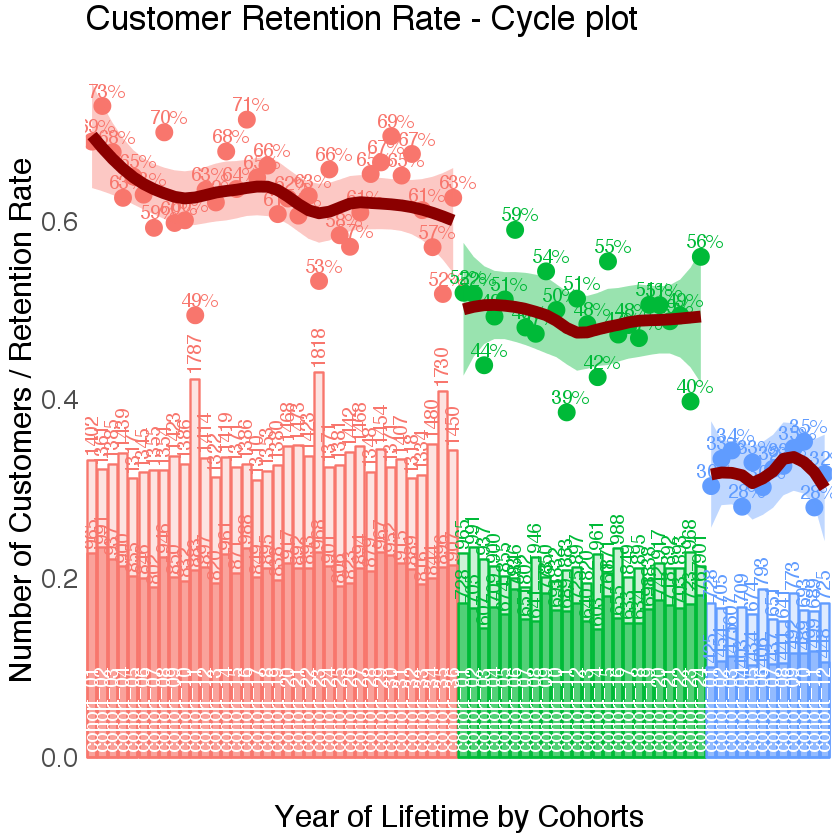

In [4]:
# calculating retention rate and preparing data for plotting
df_plot <- melt(cohorts, id.vars = 'cohort', value.name = 'number', variable.name = 'year_of_LT')
 
df_plot <- df_plot %>%
 group_by(cohort) %>%
 arrange(year_of_LT) %>%
 mutate(number_prev_year = lag(number),
 number_Y_00 = number[which(year_of_LT == 'Y_00')]) %>%
 ungroup() %>%
 mutate(ret_rate_prev_year = number / number_prev_year,
 ret_rate = number / number_Y_00,
 year_cohort = paste(year_of_LT, cohort, sep = '-'))
 
##### The first way for plotting cycle plot via scaling
# calculating the coefficient for scaling 2nd axis
k <- max(df_plot$number_prev_year[df_plot$year_of_LT == 'Y_01'] * 1.15) / min(df_plot$ret_rate[df_plot$year_of_LT == 'Y_01'])
 
# retention rate cycle plot
ggplot(na.omit(df_plot), aes(x = year_cohort, y = ret_rate, group = year_of_LT, color = year_of_LT)) +
 theme_bw() +
 geom_point(size = 4) +
 geom_text(aes(label = percent(round(ret_rate, 2))),
 size = 4, hjust = 0.4, vjust = -0.6, fontface = "plain") +
 # smooth method can be changed (e.g. for "lm")
 geom_smooth(size = 2.5, method = 'loess', color = 'darkred', aes(fill = year_of_LT)) +
 geom_bar(aes(y = number_prev_year / k, fill = year_of_LT), alpha = 0.2, stat = 'identity') +
 geom_bar(aes(y = number / k, fill = year_of_LT), alpha = 0.6, stat = 'identity') +
 geom_text(aes(y = 0, label = cohort), color = 'white', angle = 90, size = 4, hjust = -0.05, vjust = 0.4) +
 geom_text(aes(y = number_prev_year / k, label = number_prev_year),
 angle = 90, size = 4, hjust = -0.1, vjust = 0.4) +
 geom_text(aes(y = number / k, label = number),
 angle = 90, size = 4, hjust = -0.1, vjust = 0.4) +
 theme(legend.position='none',
 plot.title = element_text(size=20, face="bold", vjust=2),
 axis.title.x = element_text(size=18, face="bold"),
 axis.title.y = element_text(size=18, face="bold"),
 axis.text = element_text(size=16),
 axis.text.x = element_blank(),
 axis.ticks.x = element_blank(),
 axis.ticks.y = element_blank(),
 panel.border = element_blank(),
 panel.grid.major = element_blank(),
 panel.grid.minor = element_blank()) +
 labs(x = 'Year of Lifetime by Cohorts', y = 'Number of Customers / Retention Rate') +
 ggtitle("Customer Retention Rate - Cycle plot")
 

However, it is always helpful to analyze and visualize both relative (Customer Retention Rate) and absolute values (number of customers in a cohort). For this, I have created charts that combine these values.

Note: you can find two approaches for plotting this chart with R language at the end of the post (via scaling and via multi-plotting).

Let’s go over this chart. There are both the trend and the year of lifetime effect. Cohorts are composed of the periods of their lifetimes (annual in our case) sequentially:  the first year is red, the second one is green, and the third one is blue. There are Retention Rate indexes (points) with smooth curves on the top of the chart and the number of customers (bars) on the bottom. Light bars are the absolute numbers of customers that we had at the beginning of the exact year of the lifetime and the dark bars are the numbers of customers who were alive afterwards. For instance, the Cohort_01 had 1402 customers at the beginning of its lifetime and 965 customers after the first year. Its retention rate is 69% for the first year (965 / 1402).

Therefore, we can easily:

* compare Retention Rate and the number of customers for the newest and elder cohorts for the same period of their lifetime,
* find trends both in general and within the exact year of the lifetime,
* find outliers in both Retention Rate and the number of customers and look deeper for reasons.

We can see the flat trend in customer acquisition with seasonal picks in November (Cohort_11, Cohort_23 and Cohort_35) in our example. Although the number of customers is higher in these cohorts, the Retention Rate is lower. That means we attracted a lot of one-time buyers who were interested in discounts only but didn’t become loyal customers. We can find that Retention Rate tends to decrease in the first year. Therefore, including the flat trend in customer acquisition we would face a big problem in the business. The common Retention Rate tells us that our main losses are in the first year of the customers’ lifetime. We lost approximately 40% of clients. In addition, the third year looks problematic.

The second chart is the Bubble Chart:

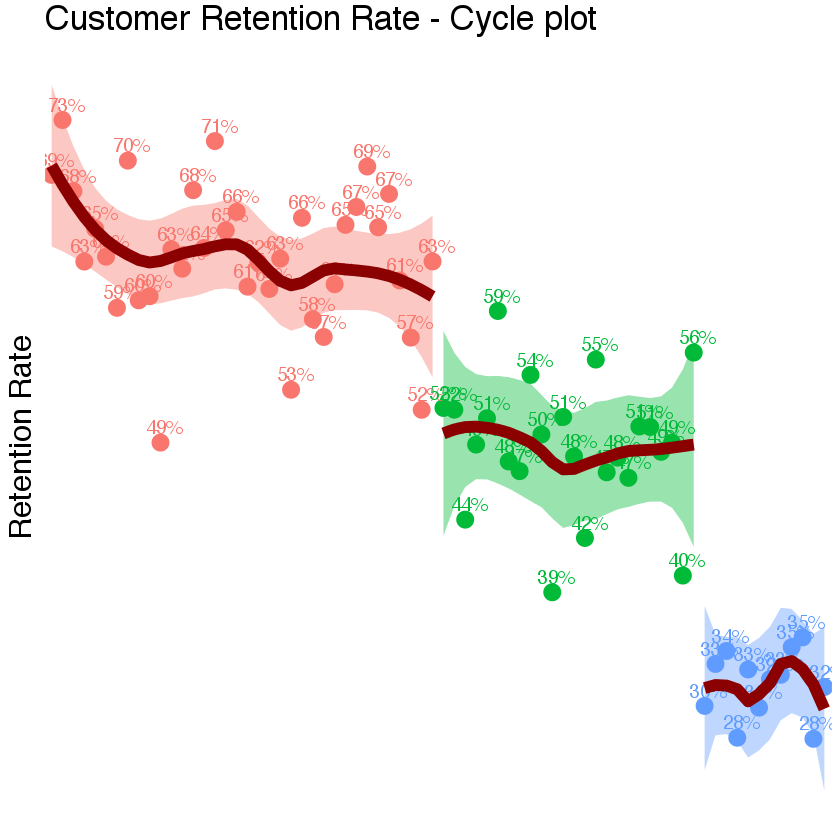

In [6]:
##### The second way for plotting cycle plot via multi-plotting
# plot #1 - Retention rate
p1 <- ggplot(na.omit(df_plot), aes(x = year_cohort, y = ret_rate, group = year_of_LT, color = year_of_LT)) +
 theme_bw() +
 geom_point(size = 4) +
 geom_text(aes(label = percent(round(ret_rate, 2))),
 size = 4, hjust = 0.4, vjust = -0.6, fontface = "plain") +
 geom_smooth(size = 2.5, method = 'loess', color = 'darkred', aes(fill = year_of_LT)) +
 theme(legend.position='none',
 plot.title = element_text(size=20, face="bold", vjust=2),
 axis.title.x = element_blank(),
 axis.title.y = element_text(size=18, face="bold"),
 axis.text = element_blank(),
 axis.ticks.x = element_blank(),
 axis.ticks.y = element_blank(),
 panel.border = element_blank(),
 panel.grid.major = element_blank(),
 panel.grid.minor = element_blank()) +
 labs(y = 'Retention Rate') +
 ggtitle("Customer Retention Rate - Cycle plot")

p1

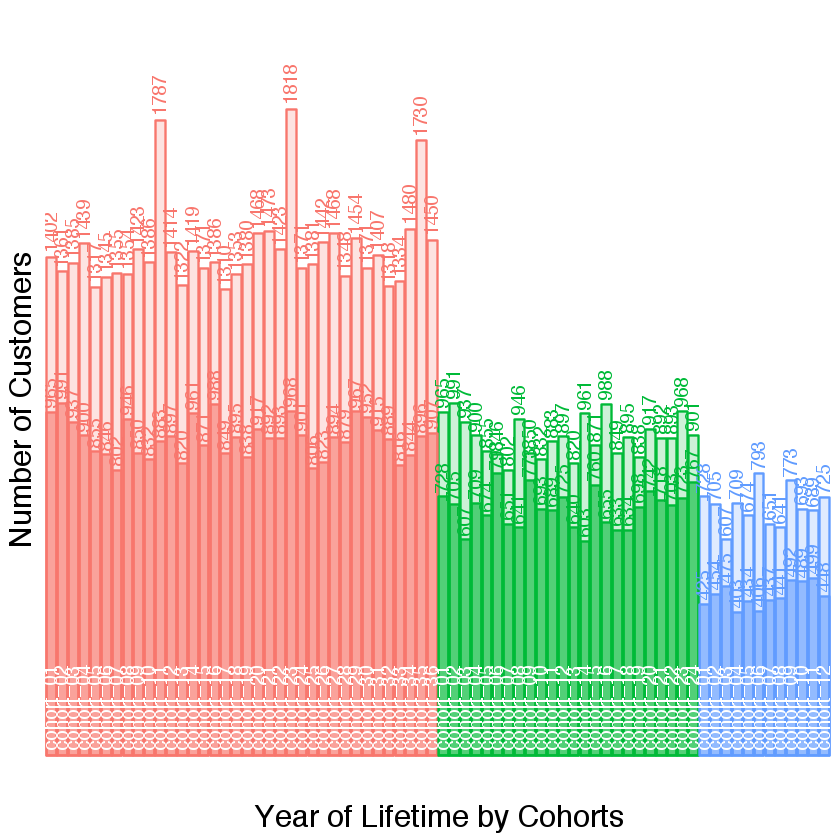

In [8]:
# plot #2 - number of customers
p2 <- ggplot(na.omit(df_plot), aes(x = year_cohort, group = year_of_LT, color = year_of_LT)) +
 theme_bw() +
 geom_bar(aes(y = number_prev_year, fill = year_of_LT), alpha = 0.2, stat = 'identity') +
 geom_bar(aes(y = number, fill = year_of_LT), alpha = 0.6, stat = 'identity') +
 geom_text(aes(y = number_prev_year, label = number_prev_year),
 angle = 90, size = 4, hjust = -0.1, vjust = 0.4) +
 geom_text(aes(y = number, label = number),
 angle = 90, size = 4, hjust = -0.1, vjust = 0.4) +
 geom_text(aes(y = 0, label = cohort), color = 'white', angle = 90, size = 4, hjust = -0.05, vjust = 0.4) +
 theme(legend.position='none',
 plot.title = element_text(size=20, face="bold", vjust=2),
 axis.title.x = element_text(size=18, face="bold"),
 axis.title.y = element_text(size=18, face="bold"),
 axis.text = element_blank(),
 axis.ticks.x = element_blank(),
 axis.ticks.y = element_blank(),
 panel.border = element_blank(),
 panel.grid.major = element_blank(),
 panel.grid.minor = element_blank()) +
 scale_y_continuous(limits = c(0, max(df_plot$number_Y_00 * 1.1))) +
 labs(x = 'Year of Lifetime by Cohorts', y = 'Number of Customers')
p2

We have all of the cohorts on the x-axis and transformed bars with the number of customers into bubbles. Light bubbles are the numbers of customers at the beginning of the lifetime period and dark bubbles are alive customers afterwards. The size of the bubbles depends on the number of customers in the cohort and the position of the bubbles depends on the Retention Rate value. There are exact numbers inside the bubbles e.g. 965/1402 and the Retention Rate is 69% for the first year for Cohort_1. This chart is helpful for analyzing each cohort and comparing their progress to others.

The last chart I call Hanging Bubbles:

**xxxxxxxxxx**

It is pretty the same with the Bubble Chart, but includes the original numbers of customers and is scaled exactly from 1 to 0 (from 100% to 0%) on the Retention Rate axis. Therefore, it is easy to find which cohort is closer to the “death” and which one is not.

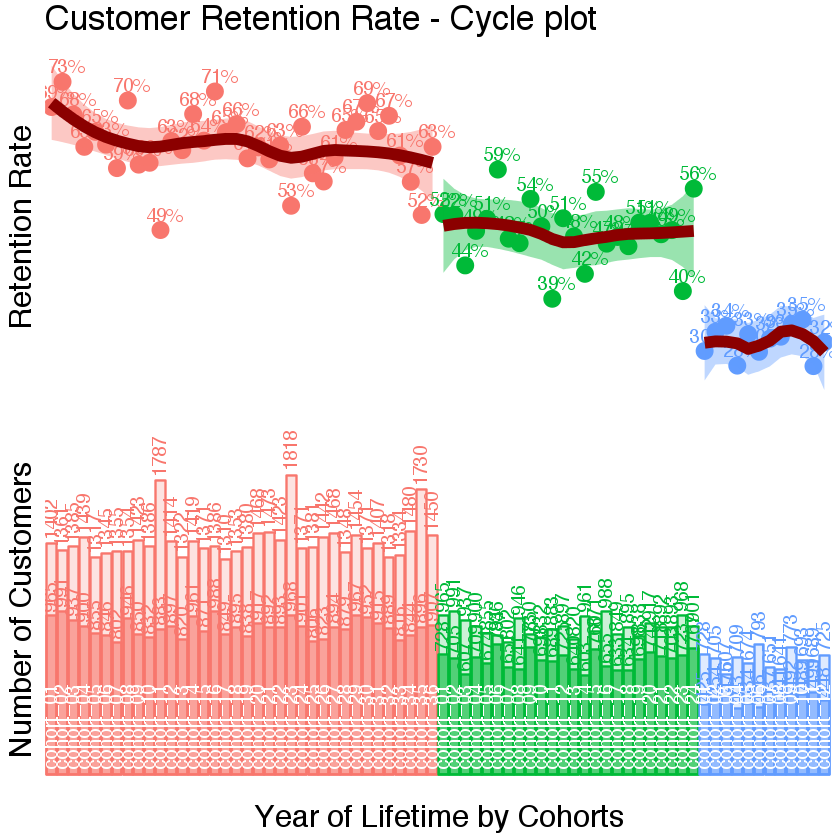

Warning message:
: Removed 36 rows containing missing values (geom_path).Warning message:
: Removed 36 rows containing missing values (geom_point).Warning message:
: Removed 36 rows containing missing values (geom_text).

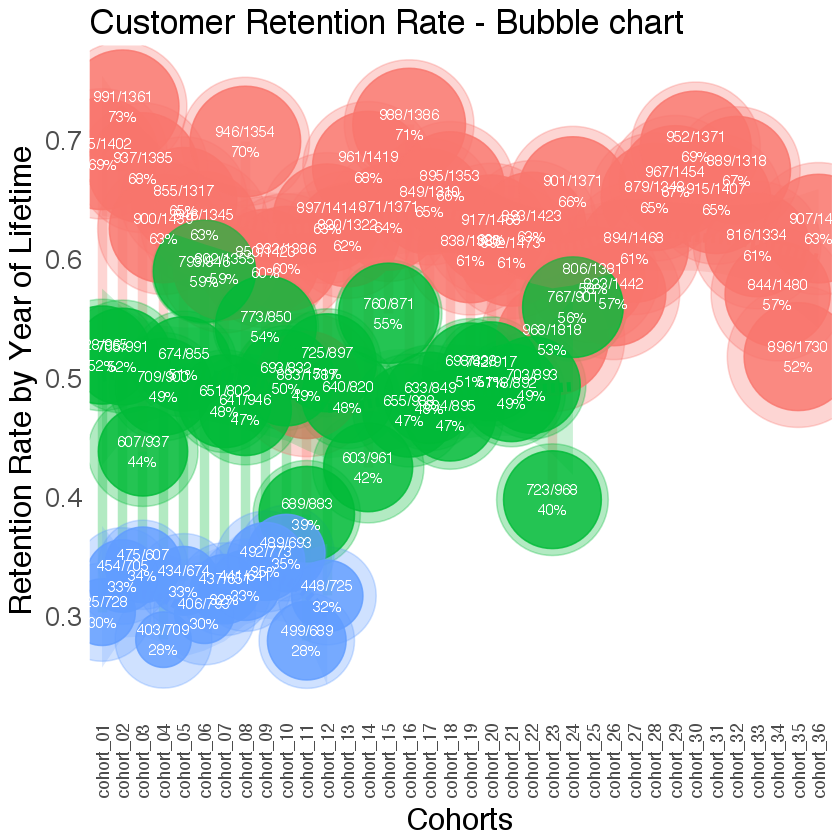

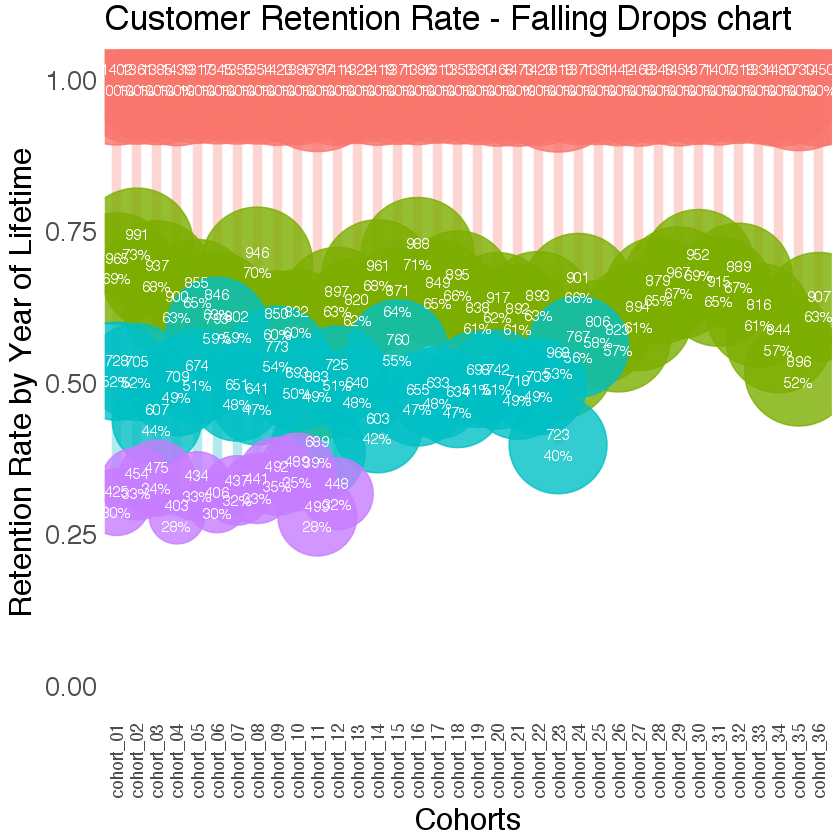

In [9]:
# multiplot
grid.arrange(p1, p2, ncol = 1)
# retention rate bubble chart
ggplot(na.omit(df_plot), aes(x = cohort, y = ret_rate, group = cohort, color = year_of_LT)) +
 theme_bw() +
 scale_size(range = c(15, 40)) +
 geom_line(size = 2, alpha = 0.3) +
 geom_point(aes(size = number_prev_year), alpha = 0.3) +
 geom_point(aes(size = number), alpha = 0.8) +
 geom_smooth(linetype = 2, size = 2, method = 'loess', aes(group = year_of_LT, fill = year_of_LT), alpha = 0.2) +
 geom_text(aes(label = paste0(number, '/', number_prev_year, '\n', percent(round(ret_rate, 2)))),
 color = 'white', size = 3, hjust = 0.5, vjust = 0.5, fontface = "plain") +
 theme(legend.position='none',
 plot.title = element_text(size=20, face="bold", vjust=2),
 axis.title.x = element_text(size=18, face="bold"),
 axis.title.y = element_text(size=18, face="bold"),
 axis.text = element_text(size=16),
 axis.text.x = element_text(size=10, angle=90, hjust=.5, vjust=.5, face="plain"),
 axis.ticks.x = element_blank(),
 axis.ticks.y = element_blank(),
 panel.border = element_blank(),
 panel.grid.major = element_blank(),
 panel.grid.minor = element_blank()) +
 labs(x = 'Cohorts', y = 'Retention Rate by Year of Lifetime') +
 ggtitle("Customer Retention Rate - Bubble chart")
 
# retention rate falling drops chart
ggplot(df_plot, aes(x = cohort, y = ret_rate, group = cohort, color = year_of_LT)) +
 theme_bw() +
 scale_size(range = c(15, 40)) +
 scale_y_continuous(limits = c(0, 1)) +
 geom_line(size = 2, alpha = 0.3) +
 geom_point(aes(size = number), alpha = 0.8) +
 geom_text(aes(label = paste0(number, '\n', percent(round(ret_rate, 2)))),
 color = 'white', size = 3, hjust = 0.5, vjust = 0.5, fontface = "plain") +
 theme(legend.position='none',
 plot.title = element_text(size=20, face="bold", vjust=2),
 axis.title.x = element_text(size=18, face="bold"),
 axis.title.y = element_text(size=18, face="bold"),
 axis.text = element_text(size=16),
 axis.text.x = element_text(size=10, angle=90, hjust=.5, vjust=.5, face="plain"),
 axis.ticks.x = element_blank(),
 axis.ticks.y = element_blank(),
 panel.border = element_blank(),
 panel.grid.major = element_blank(),
 panel.grid.minor = element_blank()) +
 labs(x = 'Cohorts', y = 'Retention Rate by Year of Lifetime') +
 ggtitle("Customer Retention Rate - Falling Drops chart")